В этом блокноте собирается простая GAN для генерации портретов котов. База взята с kaggle. Обучение проходит с использованием моего модуля GENIE (GAN: enjoy-nixe-interface-easy) с помощью которого можно не только мониторить процесс обучения, но и управлять им - для этого нужно написать свои колбеки. Не могу сказать что это открывает какие-то невероятные возможности в плане качества обучения, но помогают увидеть и, отчасти, понять что именно и как влияет на этот процесс. Ради этого genie и создавалась.

Сеть специально сделана так чтобы генерировать котов из шума размерностью (3,) т.е. всего из трех чисел. Это дает возможность создать интерфейс с ползунками, управляя которыми можно задавать параметры шума и смотреть на изменения в генерации. Эдакий эквалайзер для котов. Пример на ipywidgets в конце блокнота.

А еще, в тренеровочных целях я сделал web-вариант на базе flask:
http://207.154.226.58/cat-generator 

# импорты

In [18]:
import os
import keras
import shutil
import random
import numpy as np
from tqdm import tqdm
import tensorflow as tf
from keras import layers
import matplotlib.pyplot as plt
from IPython.display import Image
from keras.preprocessing import image
from IPython.core.display import clear_output

# подготовка датасета

In [16]:
"""
  скачивание архива с котами, взято с kaggle:
  https://www.kaggle.com/datasets/spandan2/cats-faces-64x64-for-generative-models
"""
!gdown 'https://drive.google.com/uc?id=1SFnAbAUzAbcCmp-lmgqz2ZnV__EoVPzG' 

Downloading...
From: https://drive.google.com/uc?id=1SFnAbAUzAbcCmp-lmgqz2ZnV__EoVPzG
To: /content/cats64.zip
100% 101M/101M [00:00<00:00, 182MB/s] 


In [19]:
# распаковка
if not os.path.exists('cats'):
  !unzip -q '/content/cats64.zip'

In [20]:
X = []
random.seed(99)
for catfile in tqdm(sorted(os.listdir('cats/cats'), key=lambda x: random.random())):
  img = image.load_img('cats/cats/'+catfile, color_mode='rgb') #, color_mode='grayscale' , target_size=(32, 32)
  x = image.img_to_array(img)
  X.append(x / 255.0)
# 
X = np.array(X)
X.shape

100%|██████████| 15747/15747 [00:06<00:00, 2358.17it/s]


(15747, 64, 64, 3)

In [ ]:
dataset = tf.data.Dataset.from_tensor_slices(X)

In [ ]:
def get_noise(num):
  return [np.random.normal(0, 3, size=(num, noise_shape))]

In [ ]:
noise_shape = 3
image_shape = (64, 64, 3)

NOISE = get_noise(1)
NOISES = get_noise(100)
NOISEZ = get_noise(9)

# сетки

In [ ]:
maxl = 96
actf = 'tanh' #tanh LeakyReLU

input_noise = keras.Input(shape=(noise_shape,))

x = layers.Dense(maxl * 8 * 1, activation='tanh')(input_noise)
x = layers.Dense(maxl * 8 * 4, activation=actf)(x)
x = layers.Dense(maxl * 8 * 8, activation=actf)(x)

x = layers.Dropout(0.5)(x)
x = layers.Reshape((8, 8, maxl))(x)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)
x16 = layers.Conv2D(3, 7, activation='sigmoid', padding='same')(x)
x16 = layers.UpSampling2D(size=4)(x16)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)
x32 = layers.Conv2D(3, 7, activation='sigmoid', padding='same')(x)
x32 = layers.UpSampling2D(size=2)(x32)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)
x64 = layers.Conv2D(3, 7, activation='sigmoid', padding='same')(x)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)
x128 = layers.Conv2D(3, 7, activation='sigmoid', padding='same')(x)
x128 = layers.MaxPooling2D()(x128)

x = layers.Average()([x16, x32, x64, x128])
# x = layers.Maximum()([x16, x32, x64, x128])
# x = layers.Conv2D(3, 1, activation='sigmoid', padding='same')(x)

generator = keras.models.Model(input_noise, x, name='generator')            
# generator.summary()
generator.count_params()

24068748

In [ ]:
maxl = 128
actf = 'tanh' #tanh LeakyReLU

input_noise = keras.Input(shape=(noise_shape,))

x = layers.Dense(128, activation='tanh')(input_noise)
x = layers.Dense(768, activation='tanh')(x)
x = layers.Dense(1024, activation='tanh')(x)
x = layers.Dense(16 * 16 * maxl, activation='tanh')(x)

x = layers.Dropout(0.25)(x)
x = layers.Reshape((16, 16, maxl))(x)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)

x = layers.Conv2D(maxl, 5, padding='same', activation=actf)(x)
x = layers.Conv2DTranspose(maxl, 4, strides=2, padding='same', activation=actf)(x)
x = layers.Conv2D(maxl, 3, padding='same', activation=actf)(x)

x = layers.Conv2D(3, 7, padding='same', activation='sigmoid')(x)
x = layers.MaxPooling2D()(x)

generator = keras.models.Model(input_noise, x, name='generator')            
# generator.summary()
generator.count_params()

36951811

In [ ]:
input_image = layers.Input(shape=image_shape)
x = layers.Conv2D(128, 3, activation='LeakyReLU')(input_image)
x = layers.Conv2D(128, 4, strides=2, activation='LeakyReLU')(x)
x = layers.Conv2D(128, 4, strides=2, activation='LeakyReLU')(x)
x = layers.Conv2D(128, 4, strides=2, activation='LeakyReLU')(x)
x = layers.Conv2D(128, 4, strides=2, activation='LeakyReLU')(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)

discriminator = keras.models.Model(input_image, x, name='discriminator')
# discriminator.summary()

discriminator_optimizer = keras.optimizers.rmsprop_v2.RMSprop(
    learning_rate=0.0004,
    clipvalue=1.0,
    rho=0.5,
    # decay=1e-8
    )
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
discriminator.trainable = False

gan_input = keras.Input(shape=(noise_shape,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output, name='combined_GAN')

gan_optimizer = keras.optimizers.rmsprop_v2.RMSprop(learning_rate=0.0002, clipvalue=1.0, rho=0.5) #, decay=1e-8, clipvalue=1.0
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# функция обучения

In [ ]:
def lr_gen_decrease(self):
  lr_now = keras.backend.get_value(gan.optimizer.lr)
  lr_new = lr_now * 0.98
  gan.optimizer.lr.assign(lr_new)
  with genie.output_for_console:
    clear_output()
    print(f'LR of Generator changed from {lr_now} to {lr_new}')

def lr_gen_increase(self):
  lr_now = keras.backend.get_value(gan.optimizer.lr)
  lr_new = lr_now / 0.98
  gan.optimizer.lr.assign(lr_new)
  with genie.output_for_console:
    clear_output()
    print(f'LR of Generator changed from {lr_now} to {lr_new}')

def lr_den_decrease(self):
  lr_now = keras.backend.get_value(discriminator.optimizer.lr)
  lr_new = lr_now * 0.98
  discriminator.optimizer.lr.assign(lr_new)
  with genie.output_for_console:
    clear_output()
    print(f'LR of Discriminator changed from {lr_now} to {lr_new}')

def lr_den_increase(self):
  lr_now = keras.backend.get_value(discriminator.optimizer.lr)
  lr_new = lr_now / 0.98
  discriminator.optimizer.lr.assign(lr_new)
  with genie.output_for_console:
    clear_output()
    print(f'LR of Discriminator changed from {lr_now} to {lr_new}')

def clarity_decrease(self):
  clarity_now = genie.clarity
  clarity_new = clarity_now * 0.75
  genie.clarity = clarity_new
  with genie.output_for_console:
    clear_output()
    print(f'Clarity changed from {clarity_now} to {clarity_new}')

def clarity_increase(self):
  clarity_now = genie.clarity
  clarity_new = clarity_now / 0.75
  genie.clarity = clarity_new
  with genie.output_for_console:
    clear_output()
    print(f'Clarity changed from {clarity_now} to {clarity_new}')

def make_bakeup(self):
  gan.save_weights('weights_backup.tf')
  with genie.output_for_console:
    clear_output()
    print('Бэкап весов сделан')

def restore_bakeup(self):
  gan.load_weights('weights_backup.tf')
  with genie.output_for_console:
    clear_output()
    print('Веса восстановлены')

def gtc_increase(self):
  genie.gen_train_cycles += 1
  with genie.output_for_console:
    clear_output()
    print('gen train cycles increases to: ', genie.gen_train_cycles)

def gtc_decrease(self):
  genie.gen_train_cycles = genie.gen_train_cycles - 1 if genie.gen_train_cycles > 0 else 1
  with genie.output_for_console:
    clear_output()
    print('gen train cycles decreases to: ', genie.gen_train_cycles)

def dtc_increase(self):
  genie.discriminator_train_cycles += 1
  with genie.output_for_console:
    clear_output()
    print('discriminator train cycles increases to: ', genie.discriminator_train_cycles)

def dtc_decrease(self):
  genie.discriminator_train_cycles = genie.discriminator_train_cycles - 1 if genie.discriminator_train_cycles > 0 else 1
  with genie.output_for_console:
    clear_output()
    print('discriminator train cycles decreases to: ', genie.discriminator_train_cycles)


methods = [('lr G [+]', lr_gen_increase),
           ('lr G [-]', lr_gen_decrease),
           ('lr D [+]', lr_den_increase),
           ('lr D [-]', lr_den_decrease),
           ('clarity [+]', clarity_increase),
           ('clarity [-]', clarity_decrease),
           ('backup', make_bakeup),
           ('restore', restore_bakeup),
           ('tc G [+]', gtc_increase),
           ('tc G [-]', gtc_decrease),
           ('tc D [+]', dtc_increase),
           ('tc D [-]', dtc_decrease),
]

In [ ]:
# функция обучения с внедрением GENIE
def training_func(epochs=1, batch_size=32):
  dataset_batched = dataset.shuffle(buffer_size=2**16).batch(batch_size)
  
	# цикл для шагов обучения
  for epoch in range(epochs):
    for step, real_images in enumerate(dataset_batched):
      batch_size = len(real_images)
      true_labels = np.ones(batch_size)
      fake_labels = np.zeros(batch_size)

      # код обучения
      for dc in range(genie.discriminator_train_cycles):
        noises = get_noise(batch_size)
        fake_images = generator.predict(noises)
        x, y = np.vstack((real_images, fake_images)), np.hstack((true_labels, fake_labels))
        y = np.clip(y + np.random.normal(0, genie.clarity, y.shape), 0, 1)

        res_d = discriminator.train_on_batch(x, y, return_dict=True)
        if res_d['accuracy'] > 0.85:
          break

      for gc in range(genie.gen_train_cycles):
        noises = get_noise(batch_size)
        res_g = gan.train_on_batch(noises, true_labels, return_dict=True)
        if res_g['accuracy'] > 0.75:
          break

      # запись данных по метрикам в словарь истории
      genie.update_data({
          'D loss': res_d['loss'],
          'D acc.': res_d['accuracy'],
          'G loss': res_g['loss'],
          'G acc.': res_g['accuracy'],
          'lr_g': keras.backend.get_value(gan.optimizer.lr),
          'lr_d': keras.backend.get_value(discriminator.optimizer.lr),
          'clarity': genie.clarity,
          'gc': gc+1,
          'dc': dc+1,
      })

      #
      if step % 100 == 0:
        genie.clarity = genie.clarity * 0.995 if genie.clarity > 0.01 else 0.01
        #
        for net in [discriminator, gan]:
          new_lr = keras.backend.get_value(net.optimizer.lr) * 0.995
          net.optimizer.lr.assign(new_lr)
    #
    # интерфейс имеет кнопку досрочного прекращения обучения, этот код для нее
    # не пренебрегайте этим, т.к. после запуска обучения в потоке, прекратить его через остановку ячейки будет невозможно
    if genie.control_command_code == 'stop_training':
      return None

# само обучение с GENIE

In [ ]:
# implement GENIE
!rm -r genie
!git clone -s -q https://github.com/roma-perceptron/gan-enjoy-nice-interface-easy.git genie
from genie import genie as GENIE
import threading

metrics_for_monitoring = ['G acc.', 'D acc.', 'G loss', 'D loss', 'lr_g', 'lr_d', 'clarity', 'gc', 'dc']
genie = GENIE.GAN_Enjoy_Nice_Interface_Easy('/content/monitoring/', metrics_for_monitoring, plt_style='ggplot', generator=generator, constant_noise=NOISEZ, preview_every=1, methods=methods)

genie.clarity = 0.05
genie.gen_train_cycles = 1
genie.discriminator_train_cycles = 1

Отлично, все готово к работе! Используй метод help() если нужно больше инофмации и примеры.


In [ ]:
epochs = 10
batch_size = 128

thread = threading.Thread(target=training_func, kwargs={'epochs': epochs, 'batch_size': batch_size})
thread.start()

# И последний шаг - запуск самого интерфейса. Данные будут обновляться автоматически.
genie.show_interface(steps=epochs * len(dataset) // batch_size)

# кажется были какие-то проблемы с GENIE при не полном числе шагов в последней эпохе

Box(children=(HTML(value='<style>\n  *_ {\n    border: 1px dotted red;\n  }\n\n  .main {\n    height: 100%;\n …

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
genie.get_animation()

Анимация GAN_1.gif из 171-ти кадров создана!


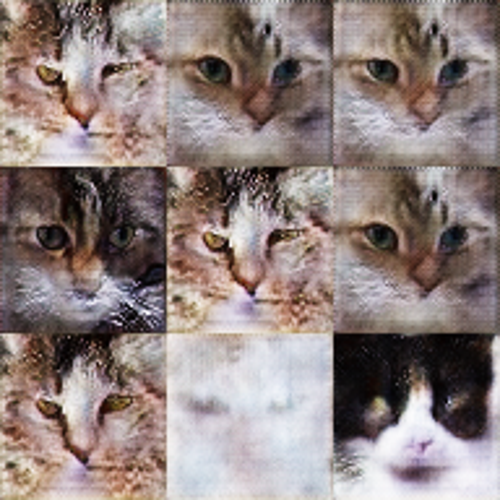

In [ ]:
genie.make_gen_preview(generator, NOISEZ, verbose=1, shift=0, resize_to=(500, 500), save=False)

In [ ]:
# если нужно выключить thread
thread._tstate_lock = None
thread._stop()

In [ ]:
# отображение гифки сделанной genie
import ipywidgets as widgets
with open('/content/monitoring/GAN_1.gif', 'rb') as gif_file:
  gifer = widgets.Image(value=gif_file.read(), format='gif', width=300)
  display(gifer)

# код интерфейса на виджетах

In [ ]:
from PIL import Image
from ipywidgets import widgets
import io
latent_dim = noise_shape
# 
size = 250
cat = 0 #32
start_data = NOISES[0][:64]
start_data[0] = [-3, 3, -3] 

def arr_to_PILImage(arr):
  arr = (255 * arr).astype('uint8')
  img = Image.fromarray(arr, mode='RGB')
  img.format = 'jpeg'
  # 
  return img

def PILImage_to_bytes(image:Image):
  # 
  imgByteArr = io.BytesIO()
  image.save(imgByteArr, format=image.format)
  # 
  return imgByteArr.getvalue()

def update_graph(data):
  with graph:
    clear_output(wait=True)

    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.scatter(data[0], data[1], data[2], 'red', s=100)
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Y')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.set_zlim(-3, 3)
    ax.view_init(None, -45)

    for i in range(3):
      poo = [[0, 0] for i in range(3)]
      poo[i] = [-3, 3]
      ax.plot3D(poo[0], poo[1], poo[2], c='k', linestyle=':', linewidth=1)
    plt.show()

def update_cat(self):
  data = np.array([[s.value for s in sliders]])
  decoded = generator.predict(data)[0]

  image_PILObj = arr_to_PILImage(decoded)
  image_bytes = PILImage_to_bytes(image_PILObj)
  imgw.value = image_bytes

  update_graph(data[0])


def set_example_data(self):
  data = start_data[example_slider.value]
  for i, v in enumerate(data):
    sliders[i].value = v
  # 

imgw = widgets.Image(width='{}px'.format(size))

layout = widgets.Layout(
    margin='0px 0px 0px 0px',
    grid_template_columns='repeat({}, {}px)'.format(np.prod(latent_dim)+1, size//np.prod(latent_dim))
)


# sliders
sliders = [widgets.FloatSlider(0, min=-3, max=3, step=0.01, description='xyz'[i], readout=True, orientation='vertical', continuous_update=False) for i in range(latent_dim)]
example_slider = widgets.IntSlider(cat, min=0, max=63, description='Примеры', readout=True, continuous_update=False)

graph = widgets.Output()

# set onchange-like event listener
example_slider.observe(set_example_data, names='value')

for slider in sliders:
  slider.observe(update_cat, names='value')

# собственно котолайзер, 3-х полосный

In [ ]:
# intitial cat & interface loading
display(widgets.HBox([imgw, widgets.GridBox(sliders, layout=layout), graph]), example_slider) 
set_example_data(None)

IntSlider(value=0, continuous_update=False, description='Примеры', max=63)